![](LOGO%20ITM%202020-2-03.png)

# APLICACION DE INTELIGENCIA ARTIFICIAL EN IMAGENES DIAGNOSTICAS USANDO TRANSFER LEARNING DENSENET Y PYTORCH

## ¿ Qué es Pytorch ?
Pytorch es un framework de redes neuronales, un conjunto de librerías y herramientas que nos hacen la vida más fácil a la hora de diseñar, entrenar y poner en producción nuestros modelos de Deep Learning. Una forma sencilla de entender qué es Pytorch es la siguiente:

Pytorch = Numpy + Autograd + GPUPytorch=Numpy+Autograd+GPU

Vamos a ver qué significa cada uno de estos términos.

* NumPy

Quizás la característica más relevante de Pytorch es su facilidad de uso. Esto es debido a que sigue una interfaz muy similar a la de NumPy, y como nosotros ya sabemos trabajar con esta librería no deberíamos tener muchos problemas para aprender a trabajar con Pytorch 😁.
De la misma manera que en NumPy el objeto principal es el ndarray, en Pytorch el objeto principal es el tensor. Podemos definir un tensor de manera similar a como definimos un array, incluso podemos inicializar tensores a partir de arrays

* Autograd

Ya hemos visto que Pytorch es muy similar a NumPy, sin embargo su funcionalidad va más allá de una estructura de datos eficiente con la que podemos llevar a cabo operaciones (para eso ya nos basta con NumPy). La funcionalidad más importante que Pytorch añade es la conocidad como autograd, la cual nos proporciona la posibilidad de calcular derivadas de manera automática con respecto a cualquier tensor. Esto le da a Pytorch un gran potencial para diseñar redes neuronales complejas y entrenarlas utilizando algoritmos de gradientes sin tener que calcular todas estas derivadas manualmente. Para poder llevar a cabo estas operaciones, Pytorch va construyendo de manera dinámica un grafo computacional. Cada vez que aplicamos una operación sobre uno o varios tensores, éstos se añaden al grafo computacional junto a la operación en concreto. De esta manera, si queremos calcular la derivada de cualquier valor con respecto a cualquier tensor, simplemente tenemos que aplicar el algoritmo de backpropagation (que no es más que la regla de la cadena de la derivada) en el grafo. 

* GPU

En su mayoría, nuestros modelos llevan a cabo una operación simple: el producto de matrices. Esta operación puede ser muy lenta si estas matrices son muy grandes. Sin embargo, existe hardware especializado en acelerar precisamente este tipo de operaciones: las unidades de procesado gráfico, o GPUs.
Pytorch nos permite acelerar las operaciones entre tensores de manera muy sencilla. Simplemente tenemos que asegurarnos que nuestros tensores viven en una GPU, Pytorch se encargará del resto.



## 1. CARGA DE DATOS

Aca vemos todos los datos y sus posibles desbalanceos

Importación de las bibliotecas necesarias

In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
import random
import cv2
import copy
import os
import time
from sklearn.model_selection import train_test_split
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torchvision.transforms as transform
from torch.utils.data import Dataset, DataLoader, ConcatDataset


 


Funciones para determinar el uso del procesamietno por medio de GPU o CPU.

In [2]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()
device

device(type='cpu')

Se designa la ruta de carpeta de trabajo donde se encuentran las imaganes como una variable para no escribir una ruta larga

In [3]:
path = 'H:/My Drive/Colab Notebooks/AI-Imagen-Diagnosticas/chest_xray/chest_xray'

Veamos la distribución de los datos. Como podemos ver, hay un fuerte desequilibrio en los datos (hay muchas veces más radiografías con neumonía que normales), hay muchas soluciones al problema del desequilibrio. una solución a continuación.

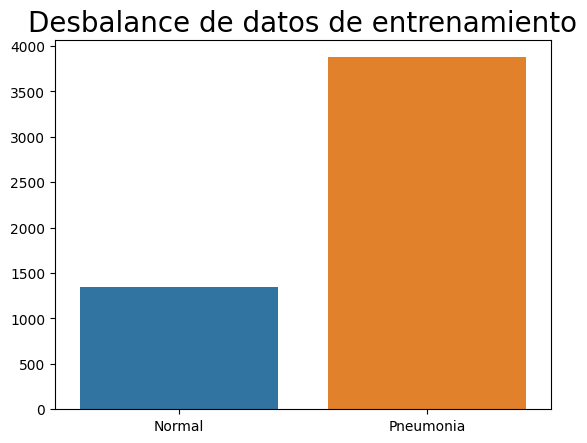

In [4]:
train_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/train/NORMAL', filename) 
                     for filename in os.listdir(path+'/train/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/train/NEUMONIA', filename) 
                        for filename in os.listdir(path+'/train/PNEUMONIA')])]})


sns.barplot(data=train_samplesize).set_title('Desbalance de datos de entrenamiento', fontsize=20)
plt.show()

en este punto es mejor aumentar el conjunto de datos con las radiografías normales. La diferencia entre los datos de neumonía y los normales es de 2534, es decir, para nivelar, necesitamos añadir 2534 radiografías normales. Como sólo hay 1341 imágenes normales en la carpeta 'train', tomaremos las 1193 imágenes que faltan del tercer conjunto de datos. Para evitar los objetos duplicados en el conjunto de datos final, se aplica un aumento único para cada conjunto de datos.

Aquí están los aumentos para los conjuntos de datos

In [5]:
transformer = {##realizar tratamiento a als imagenes
    'dataset1': transform.Compose([transform.Resize(255), ## asignarles un tamaño
                                            transform.CenterCrop(224), ## recortar la imagen 
                                            transform.RandomHorizontalFlip(), ##girarla en el eje horizontal
                                            transform.RandomRotation(10),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.05,0.05), degrees=0),
                                            transform.ToTensor() ##convertir en tensor
                                           ]),
    
    'dataset2' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=1),
                                            transform.RandomGrayscale(),
                                            transform.RandomAffine(translate=(0.1,0.05), degrees=10),
                                            transform.ToTensor()
                                    
                                           ]),
    'dataset3' : transform.Compose([transform.Resize(255),
                                            transform.CenterCrop(224),
                                            transform.RandomHorizontalFlip(p=0.5),
                                            transform.RandomRotation(15),
                                            transform.RandomGrayscale(p=1),
                                            transform.RandomAffine(translate=(0.08,0.1), degrees=15),
                                            transform.ToTensor()
                                           ]),
}

Se crea un conjuntos de datos y se concatena estos mismos

In [6]:
dataset1 = ImageFolder(path+'/train', 
                      transform=transformer['dataset1'])

dataset2 = ImageFolder(path+'/train', 
                      transform=transformer['dataset2'])

dataset3 = ImageFolder(path+'/train', 
                      transform=transformer['dataset3'])

norm1, _ = train_test_split(dataset2, test_size= 3875/(1341+3875), shuffle=False)
norm2, _ = train_test_split(dataset3, test_size= 4023/(1341+3875), shuffle=False)

dataset = ConcatDataset([dataset1, norm1, norm2])

len(dataset)

7750

Sabemos de antemano qué clases hay, pero a veces es útil poder ver las clases del conjunto de datos

In [7]:
print(dataset1.classes)

['NORMAL', 'PNEUMONIA']


Veamos  una muestra de las radiografías con los diagnósticos. (aun que personalemente no veo ninguna diferencia entre una radiografía de neumonía y una radiografía normal)

In [8]:
# Función de gráfico de muestras
def plot_samples(samples):  
    fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,8))
    for i in range(len(samples)):
        image = cv2.cvtColor(imread(samples[i]), cv2.COLOR_BGR2RGB)
        ax[i//5][i%5].imshow(image)
        if i<5:
            ax[i//5][i%5].set_title("Normal", fontsize=20)
        else:
            ax[i//5][i%5].set_title("Pneumonia", fontsize=20)
        ax[i//5][i%5].axis('off')

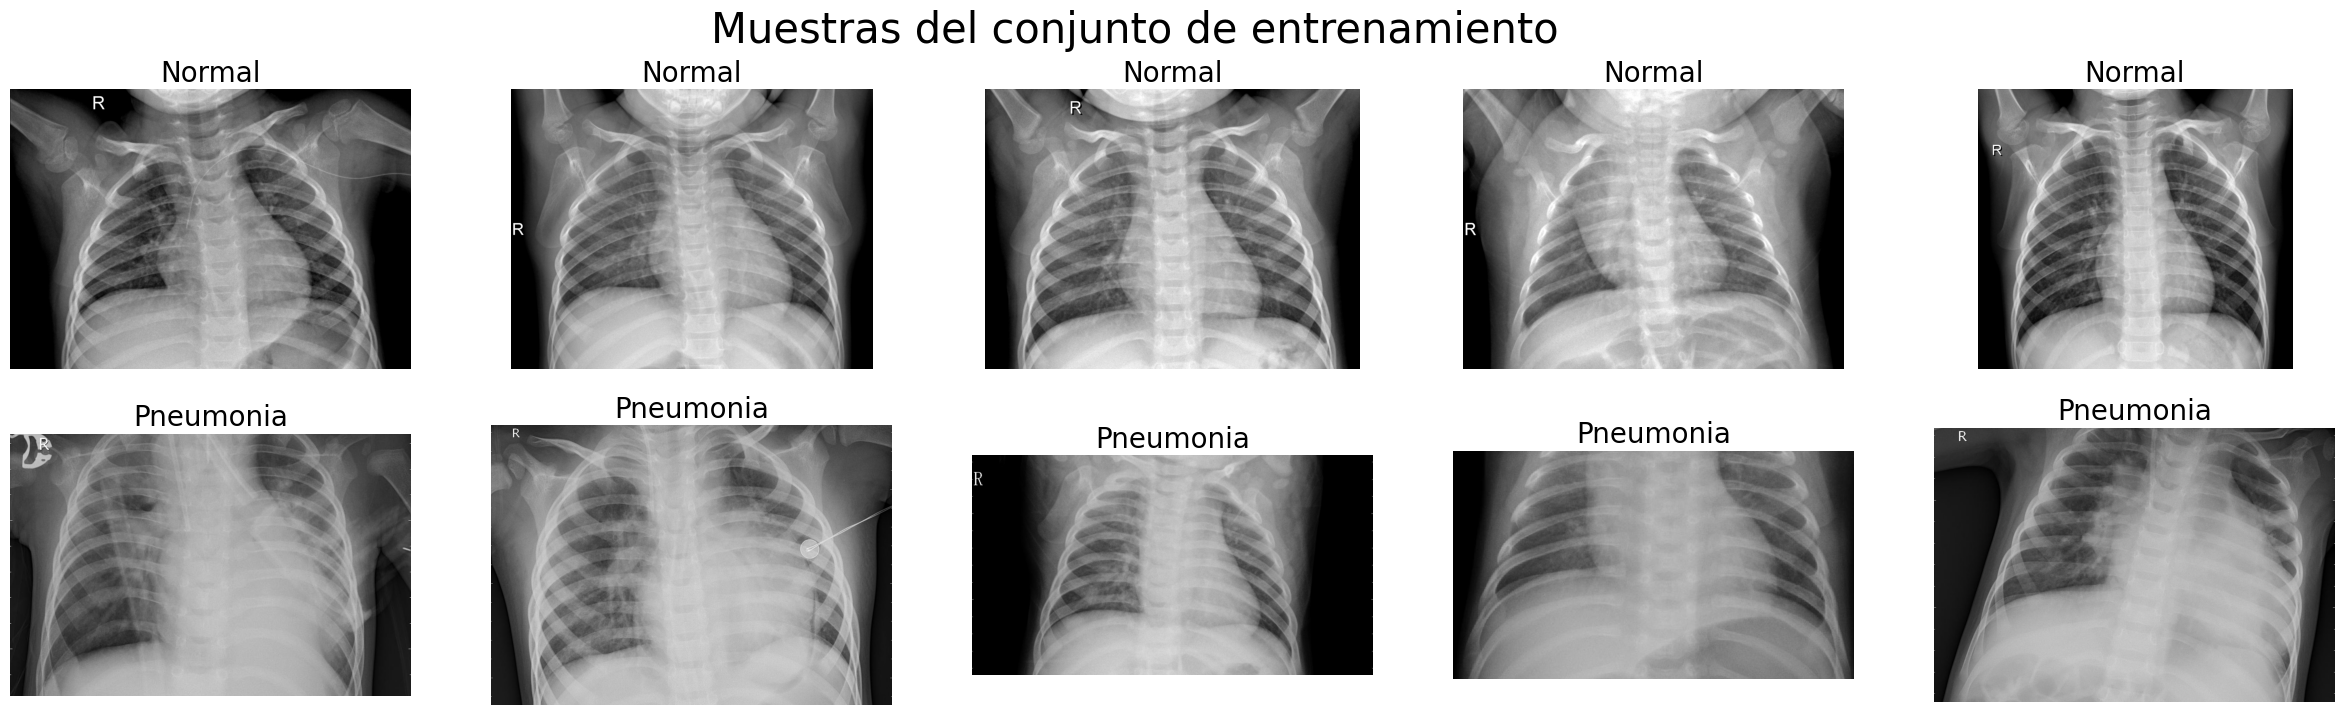

In [9]:
rand_samples = random.sample([os.path.join(path+'/train/NORMAL', filename) 
                              for filename in os.listdir(path+'/train/NORMAL')], 5) + \
    random.sample([os.path.join(path+'/train/PNEUMONIA', filename) 
                   for filename in os.listdir(path+'/train/PNEUMONIA')], 5)

plot_samples(rand_samples)
plt.suptitle('Muestras del conjunto de entrenamiento', fontsize=30)
plt.show()

## 2. PREPARACION DE DATOS PARA LA VALIDACION Y EL ENTRENAMIENTO

En esta parte, se divide la carpeta 'train' en partes de validación y entrenamiento. En este dataset,  hay una carpeta separada con la validación, pero el hecho es que sólo hay 16 imágenes y esto claramente no es suficiente para evaluar adecuadamente el modelo, por lo que hay que sacrificar parte de los datos para la validación. Se dividen los datos en una proporción de 3/10 (30%), y con 70% a favor de los datos de entrenamiento.

In [10]:
# establecer una muestra aleatoria para obtener el mismo muestreo cada vez

random_seed = 2020
torch.manual_seed(random_seed);

In [11]:
train_ds, val_ds = train_test_split(dataset, test_size=0.3, random_state=random_seed)
len(train_ds), len(val_ds)

(5425, 2325)

Vamos a empaquetar los datos en dataloaders. También se crea un diccionario con los dataloggers para tener un acceso rápido a ellos y un diccionario con sus tamaños, esto nos servirá para evaluar el modelo

La clase PyTorch DataLoader es una herramienta importante para ayudarte a preparar, gestionar y servir tus datos a tus redes de aprendizaje profundo. Debido a que muchos de los pasos de preprocesamiento que necesitarás hacer antes de comenzar a entrenar un modelo, encontrar formas de estandarizar estos procesos es fundamental para la legibilidad y la mantenibilidad de tu código.

In [12]:
batch_size=50

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
loaders = {'train':train_dl, 'val':val_dl}
dataset_sizes = {'train':len(train_ds), 'val':len(val_ds)}

Veamos cómo son los datos con el aumento.

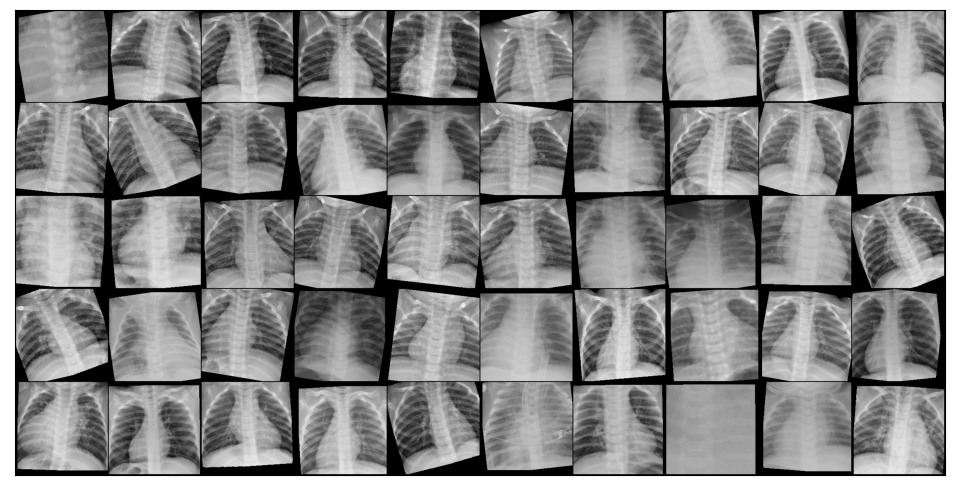

In [13]:
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:60], nrow=10).permute(1, 2, 0))
        break
        
show_batch(train_dl)

## 3. Creación del modelo

En la tercera parte, Se crea el modelo. Se toma una red densenet ya hecha y se trabaja con ella

![](datasetLearning.jpg)

A menudo, el conjunto de datos de una tarea para entrenar una red contiene pocos objetos. Y si se entrena la red en este conjunto de datos desde cero, la red se volverá a entrenar.
Idea: utilizar los conocimientos adquiridos por otras redes en tareas similares.
Se eligio DenseNet. DenseNet tiene muchas ventajas: fuerte flujo de gradiente, el número de capas y parámetros no es muy grande, las capas convulucionales destacan características más diversas, las capas convulucionales inferiores tienen en cuenta los patrones bajos y complejos de las capas superiores, lo que puede ser útil para detectar algunos patrones de bajo nivel. También ayuda a DenseNet a aprender mejor en conjuntos de datos pequeños.

### ¿Qué son las DenseNets?
DenseNet es una arquitectura de red en la que cada capa está conectada directamente a todas las demás de forma feed-forward (dentro de cada bloque denso). Para cada capa, los mapas de características de todas las capas precedentes se tratan como entradas separadas, mientras que sus propios mapas de características se transmiten como entradas a todas las capas posteriores. Este modelo de conectividad proporciona las mejores precisiones en CIFAR10/100 (con o sin aumento de datos) y SVHN. En el conjunto de datos a gran escala de ILSVRC 2012 (ImageNet), DenseNet alcanza una precisión similar a la de ResNet, pero utilizando menos de la mitad de parámetros y aproximadamente la mitad de FLOPs.

![](DenseNet.jpg)

### ¿Por qué necesitamos DenseNets?
DenseNet se desarrolló especialmente para mejorar la precisión causada por la desaparición del gradiente en las redes neuronales de alto nivel debido a la gran distancia entre las capas de entrada y salida y a que la información se desvanece antes de llegar a su destino.


#### Arquitectura DenseNet VS Arquitectura ResNet.
![](Densenet%20Vs%20resnet.png)

Supongamos que tenemos un número L de capas, En una red típica con L capas, habrá L conexiones, es decir, conexiones entre las capas.Sin embargo, en una DenseNet, habrá alrededor de L
y L más una por dos conexiones L(L+1)/2. Así que en una red densa, tenemos menos número de capas que el otro modelo, por lo que aquí podemos entrenar más de 100 capas del modelo muy fácilmente utilizando esta técnica.

Algunas ventajas de la Densenet.

* Eficiencia de los parámetros: Cada capa añade sólo un número limitado de parámetros - por ejemplo, sólo se aprenden unos 12 kernels por capa.

* Supervisión profunda implícita - Mejora del flujo de gradiente a través de la red - Los mapas de características en todas las capas tienen acceso directo a la función de pérdida y a su gradiente.


Como se tendra que calcular la precisión varias veces, se define por adelantado la función para calcular la precisión(accurancy)

In [14]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1) 
    return torch.tensor(torch.sum(preds == labels).item() / len(preds)), preds

Ahora se crea una red preentrenada

Los modelos Torch se entrenan con la misma configuración que en fb.resnet.torch. Los porcentajes de error mostrados son errores de prueba  de 224x224., en el cual se escogio el modelo Densenet-161 K=48, la cual tiene menos indice de error y una tasa de crecimiento mucho mayor. como lo vemos acontinuacion:


![](tabla%20de%20densenet.PNG)

![Alt text](../../../../H:/My%20Drive/Colab%20Notebooks/AI-Imagen-Diagnosticas/densearquitecture.PNG)


![Alt text](../../../../H:/My%20Drive/Colab%20Notebooks/AI-Imagen-Diagnosticas/densetcomparation.PNG)

Tasa de crecimiento - Esto determina el número de mapas de características que salen en las capas individuales dentro de los bloques densos.

Para descargar la red pre-entrenada

In [15]:
model = torchvision.models.densenet161(pretrained=True)

h:\My Drive\Colab Notebooks\AI-Imagen-Diagnosticas\densenet\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
h:\My Drive\Colab Notebooks\AI-Imagen-Diagnosticas\densenet\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


* Arquitectura Densenet 161
Cuando se utiliza la arquitectura DenseNet, el valor inicial se entrega directamente a la última capa, lo que reduce el número de características reutilizadas, el número de parámetros y la carga de trabajo computacional. Otra característica es que se utiliza un bloque denso para el cálculo de la agrupación. Un bloque denso se compone de varias capas y el cálculo de pooling se realiza entre los bloques densos. El cálculo de agrupación se realiza en el orden de normalización por lotes(batchs), convolución 1 × 1 y agrupación media 2 × 2, lo que se conoce como capa de transición. Las capas totalmente conectadas (FC), que anteriormente tenían 1000 salidas, se ajustaron para que tuvieran dos salidas y se afinaron con los datos de entrenamiento de este estudio.

![Alt text](../../../../H:/My%20Drive/Colab%20Notebooks/AI-Imagen-Diagnosticas/arquitecturadenset161.PNG)

Una práctica muy común a la hora de entrenar redes convolucionales es descargar un modelo ya entrenado y modificarlo para ajustarlo a nuestra tarea en particular. Por ejemplo, si queremos utilizar la red Desnenet161 para clasificar imágenes del dataset obtendremos resultados no deseados ya que la red original fue entrenada para 1000 clases, mientras que la nuestra solo tiene 2.

Las capas superiores (primeras) de la red se congelan, las inferiores se reentrenan. Las capas superiores destacan la información de bajo nivel, y han aprendido a hacerlo bien en el preentrenamiento. Las capas inferiores se separan de la información obtenida de las capas superiores, información específica de la tarea, por lo que necesitan ser reentrenadas.

El número de capas a congelar depende de la diferencia entre los conjuntos de datos, la complejidad de la tarea y el tamaño del conjunto de datos para el entrenamiento adicional. DenseNet sólo tiene una capa totalmente conectada, así que sólo la entrenaremos y congelaremos el resto de la red. También cambiaremos la última capa, ya que fue entrenada originalmente en 1000 clases, y sólo tenemos 2

In [16]:
for param in model.parameters():
    param.requires_grad = False
    
in_features = model.classifier.in_features

model.classifier = nn.Linear(in_features, 2)

In [1]:
#guardar las pérdidas para su posterior visualización
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}

Función de entrenamiento

In [18]:
def train(model, criterion, optimizer, scheduler, epochs):
  since = time.time()
  best_model = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  for epoch in range(epochs):
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0.0

      for inputs, labels in loaders[phase]:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase=='train'):
          outp = model(inputs)
          _, pred = torch.max(outp, 1)
          loss = criterion(outp, labels)
        
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        running_loss += loss.item()*inputs.size(0)
        running_corrects += torch.sum(pred == labels.data)


      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double()/dataset_sizes[phase]
      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)
      if phase == 'train':
        print('Epoch: {}/{}'.format(epoch+1, epochs))
      print('{} - loss:{}, accuracy{}'.format(phase, epoch_loss, epoch_acc))
    
      if phase == 'val':
        print('Time: {}m {}s'.format((time.time()- since)//60, (time.time()- since)%60))
            
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model = copy.deepcopy(model.state_dict())
    scheduler.step()  
  time_elapsed = time.time() - since
  print('Training Time {}m {}s'.format(time_elapsed//60, time_elapsed%60)) 
  print('Best accuracy {}'.format(best_acc))

  model.load_state_dict(best_model)
  return model   

El optimizador especificamos sólo el clasificador

Se implementa varios algoritmos de optimización. Para utilizar torch.optim hay que construir un objeto optimizador, que mantendrá el estado actual y actualizará los parámetros basándose en los gradientes calculados. 
Para construir un Optimizador hay que darle un iterable que contenga los parámetros (todos deben ser Variable s) a optimizar. Se puede especificar las opciones específicas del optimizador, como la tasa de aprendizaje, el decaimiento del peso, etc

El criterion calcula la pérdida de entropía cruzada entre los logits de entrada y el objetivo.
Es útil cuando se entrena un problema de clasificación con C clases. Si se proporciona, el argumento opcional peso debe ser un tensor 1D que asigne peso a cada una de las clases. Esto es particularmente útil cuando se tiene un conjunto de entrenamiento desequilibrado.

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.1)

scheduler - ofrece varios métodos para ajustar la tasa de aprendizaje en función del número de épocas. La programación de la tasa de aprendizaje debe aplicarse después de la actualización del optimizador; por ejemplo, debe escribir el codigo como esta anteriormente

In [23]:
model.to(device)
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.007339473819874618, accuracy0.9966820276497695
val - loss:0.07525753717549065, accuracy0.9763440860215054
Time: 38.0m 48.26557111740112s
Epoch: 2/10
train - loss:0.033275138496363335, accuracy0.9874654377880184
val - loss:0.046268702194254885, accuracy0.983225806451613
Time: 77.0m 55.21241331100464s
Epoch: 3/10
train - loss:0.006371174812100158, accuracy0.9987096774193548
val - loss:0.05901066198574519, accuracy0.9810752688172043
Time: 117.0m 43.1039674282074s
Epoch: 4/10
train - loss:0.0077786404860913025, accuracy0.9974193548387097
val - loss:0.05998736777485559, accuracy0.9797849462365591
Time: 157.0m 39.54137420654297s
Epoch: 5/10
train - loss:0.0021138350685982223, accuracy0.99926267281106
val - loss:0.05297449385366773, accuracy0.9827956989247312
Time: 197.0m 30.52145004272461s
Epoch: 6/10
train - loss:0.0022661657540209716, accuracy0.9996313364055299
val - loss:0.051361909192506106, accuracy0.984516129032258
Time: 237.0m 36.284334659576416s
Epoch: 7/10

Es una buena práctica volver a entrenar el resto de la red después de haber entrenado la última capa. En la mayoría de los casos, esto conduce a un aumento del rendimiento, pero en mi práctica ha habido casos en los que, debido a un pequeño conjunto de datos, esto condujo a una degradación del rendimiento, por lo que mi consejo es comprobar la tasa de aprendizaje, donde puede reducirse 10 veces

In [24]:
for param in model.parameters():
    param.requires_grad = True
    
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)

model.to(device)
grad_clip = None
weight_decay = 1e-4
# pérdida ponderada por desequilibrio de clases de datos
epochs = 10
model = train(model, criterion, optimizer, scheduler, epochs)

Epoch: 1/10
train - loss:0.007428527072485853, accuracy0.9981566820276497
val - loss:0.07219868532559705, accuracy0.9802150537634409
Time: 41.0m 7.754253387451172s
Epoch: 2/10
train - loss:0.007380628490285795, accuracy0.9972350230414746
val - loss:0.05713723096195408, accuracy0.9810752688172043
Time: 82.0m 19.664719104766846s
Epoch: 3/10
train - loss:0.009472725831065676, accuracy0.9966820276497695
val - loss:0.06888215158695496, accuracy0.9797849462365591
Time: 123.0m 41.314509868621826s
Epoch: 4/10
train - loss:0.004771455848996725, accuracy0.9983410138248848
val - loss:0.060587816085586305, accuracy0.9827956989247312
Time: 165.0m 21.73064398765564s
Epoch: 5/10
train - loss:0.002665722761746785, accuracy0.99926267281106
val - loss:0.04636594732992992, accuracy0.9862365591397849
Time: 207.0m 2.9007794857025146s
Epoch: 6/10
train - loss:0.000287234562815034, accuracy1.0
val - loss:0.04561890709158834, accuracy0.9866666666666667
Time: 248.0m 51.93992304801941s
Epoch: 7/10
train - loss:

In [33]:
# Guardar modelo Full
torch.save(model, 'model2.pt')

In [22]:
model = torch.load('model2.pt')
model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

## 4. Exactitud y la pérdida (accurancy, loss)

Estos son los resultados para ver cómo ha funcionado la idea con el entrenamiento adicional de toda la red, si se selecciona correctamente la tasa de aprendizaje y si la red se está reentrenando. Como se puede ver en el gráfico, la idea funcionó y se aumento la productividad.

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs*2+1))
ax1.plot(epoch_list, accuracies['train'], label='Train Accuracy')
ax1.plot(epoch_list, accuracies['val'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, epochs*2+1, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, losses['train'], label='Train Loss')
ax2.plot(epoch_list, losses['val'], label='Validation Loss')
ax2.set_xticks(np.arange(0, epochs*2+1, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

![](output4.png)

## 5. Test

Ahora se coje la red entrenada con datos que nunca se han trabajado.

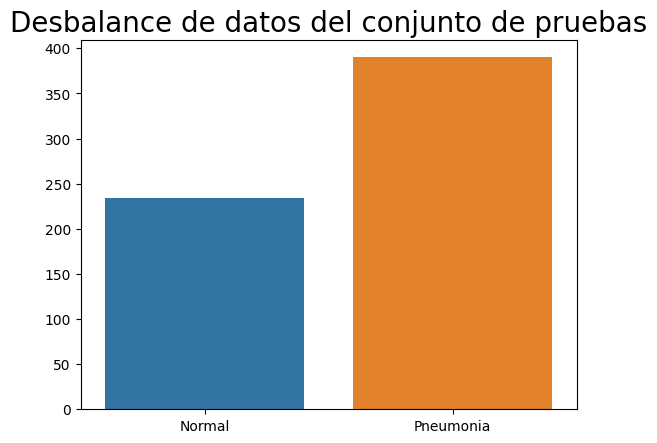

In [27]:
test_samplesize = pd.DataFrame.from_dict(
    {'Normal': [len([os.path.join(path+'/test/NORMAL', filename) 
                     for filename in os.listdir(path+'/test/NORMAL')])], 
     'Pneumonia': [len([os.path.join(path+'/test/PNEUMONIA', filename) 
                        for filename in os.listdir(path+'/test/PNEUMONIA')])]})

sns.barplot(data=test_samplesize).set_title('Desbalance de datos del conjunto de pruebas', fontsize=20)
plt.show()

Las siguientes tres funciones son necesarias para calcular las métricas

In [28]:
def validation_step(batch):
        images,labels = batch
        images,labels = images.to(device),labels.to(device)
        out = model(images)                                      
        loss = F.cross_entropy(out, labels)                    
        acc,preds = accuracy(out, labels)                       
        
        return {'val_loss': loss.detach(), 'val_acc':acc.detach(), 
                'preds':preds.detach(), 'labels':labels.detach()}

In [29]:
def test_prediction(outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()           
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()             
        # combinar las predicciones
        batch_preds = [pred for x in outputs for pred in x['preds'].tolist()] 
        # combinar etiquetas
        batch_labels = [lab for x in outputs for lab in x['labels'].tolist()]  
        
        return {'test_loss': epoch_loss.item(), 'test_acc': epoch_acc.item(),
                'test_preds': batch_preds, 'test_labels': batch_labels}  

In [30]:
@torch.no_grad()
def test_predict(model, test_loader):
    model.eval()
    # realizar pruebas para cada batch
    outputs = [validation_step(batch) for batch in test_loader] 
    results = test_prediction(outputs)                          
    print('test_loss: {:.4f}, test_acc: {:.4f}'
          .format(results['test_loss'], results['test_acc']))
    
    return results['test_preds'], results['test_labels']

Se crea un conjunto de datos con datos de entrenamiento

In [31]:
testset = ImageFolder(path+'/test', 
                           transform=transform.Compose([transform.Resize(255),
                                                 transform.CenterCrop(224),                                                              
                                                 transform.ToTensor(),
                                                ]))

Se evalua el conjunto de pruebas

In [32]:
test_dl = DataLoader(testset, batch_size=256)
model.to(device)
preds,labels = test_predict(model, test_dl)

test_loss: 0.3727, test_acc: 0.9332


## 6. Cálculo de algunas métricas y visualización de las predicciones

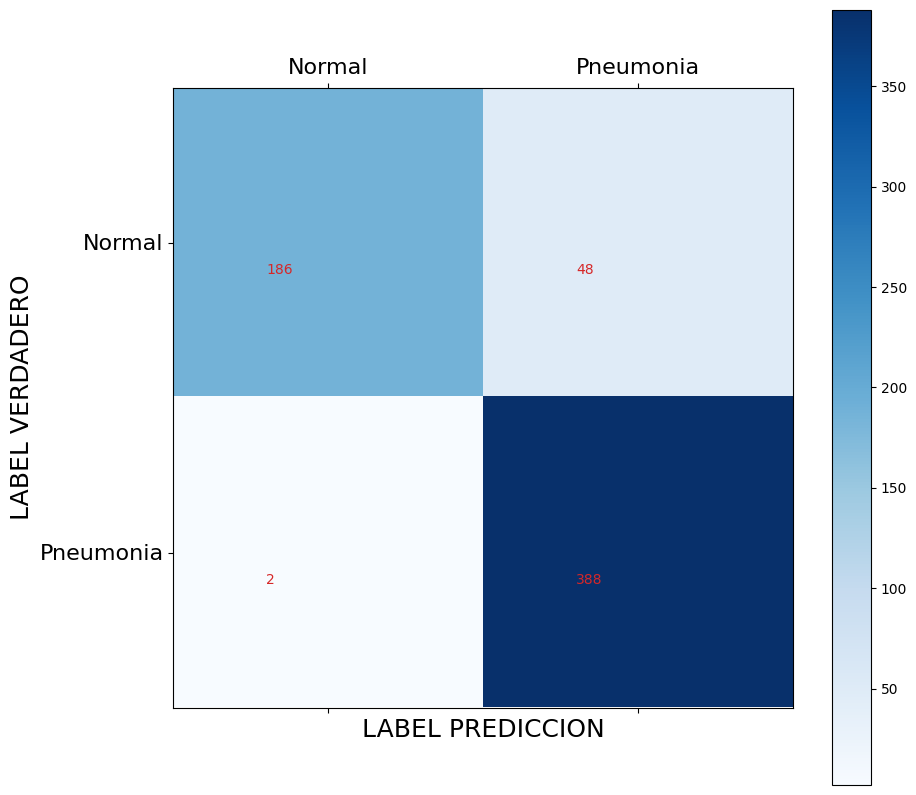

In [34]:

def plot_confusion_matrix(labels, preds):
    conf_mat = confusion_matrix(labels, preds)
    #print(conf_mat)
    fig = plt.figure(figsize=(10,10))
    plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=1)
    plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
    plt.colorbar();
    plt.xlabel('LABEL PREDICCION',fontsize=18)
    plt.ylabel('LABEL VERDADERO',fontsize=18)
    for i in range(2):
        for j in range(2):
            plt.text(i-0.2,j+0.1, str(conf_mat[j, i]), color='tab:red')
            
           
plot_confusion_matrix(labels,preds)

A continuación, vamos a calcular el recall, la precisión(accurancy) y la puntuación f1(score-f1). Esta es una de las métricas más importantes para los problemas de clasificación.
![](Pressioson%20score.png)

In [36]:
# Métricas de rendimiento informático
cm  = confusion_matrix(labels, preds)
tn, fp, fn, tp = cm.ravel()

accuracy = (np.array(preds) == np.array(labels)).sum() / len(preds)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*((precision*recall)/(precision+recall))

print("El Accuracy del modelo es {:.2f}".format(accuracy))
print("El Recall del modelo es {:.2f}".format(recall))
print("La precisión del modelo es {:.2f}".format(precision))
print("El F1 Score del modelo es {:.2f}".format(f1))

El Accuracy del modelo es 0.92
El Recall del modelo es 0.99
La precisión del modelo es 0.89
El F1 Score del modelo es 0.94


Veamos las Radiografías y Predicciones

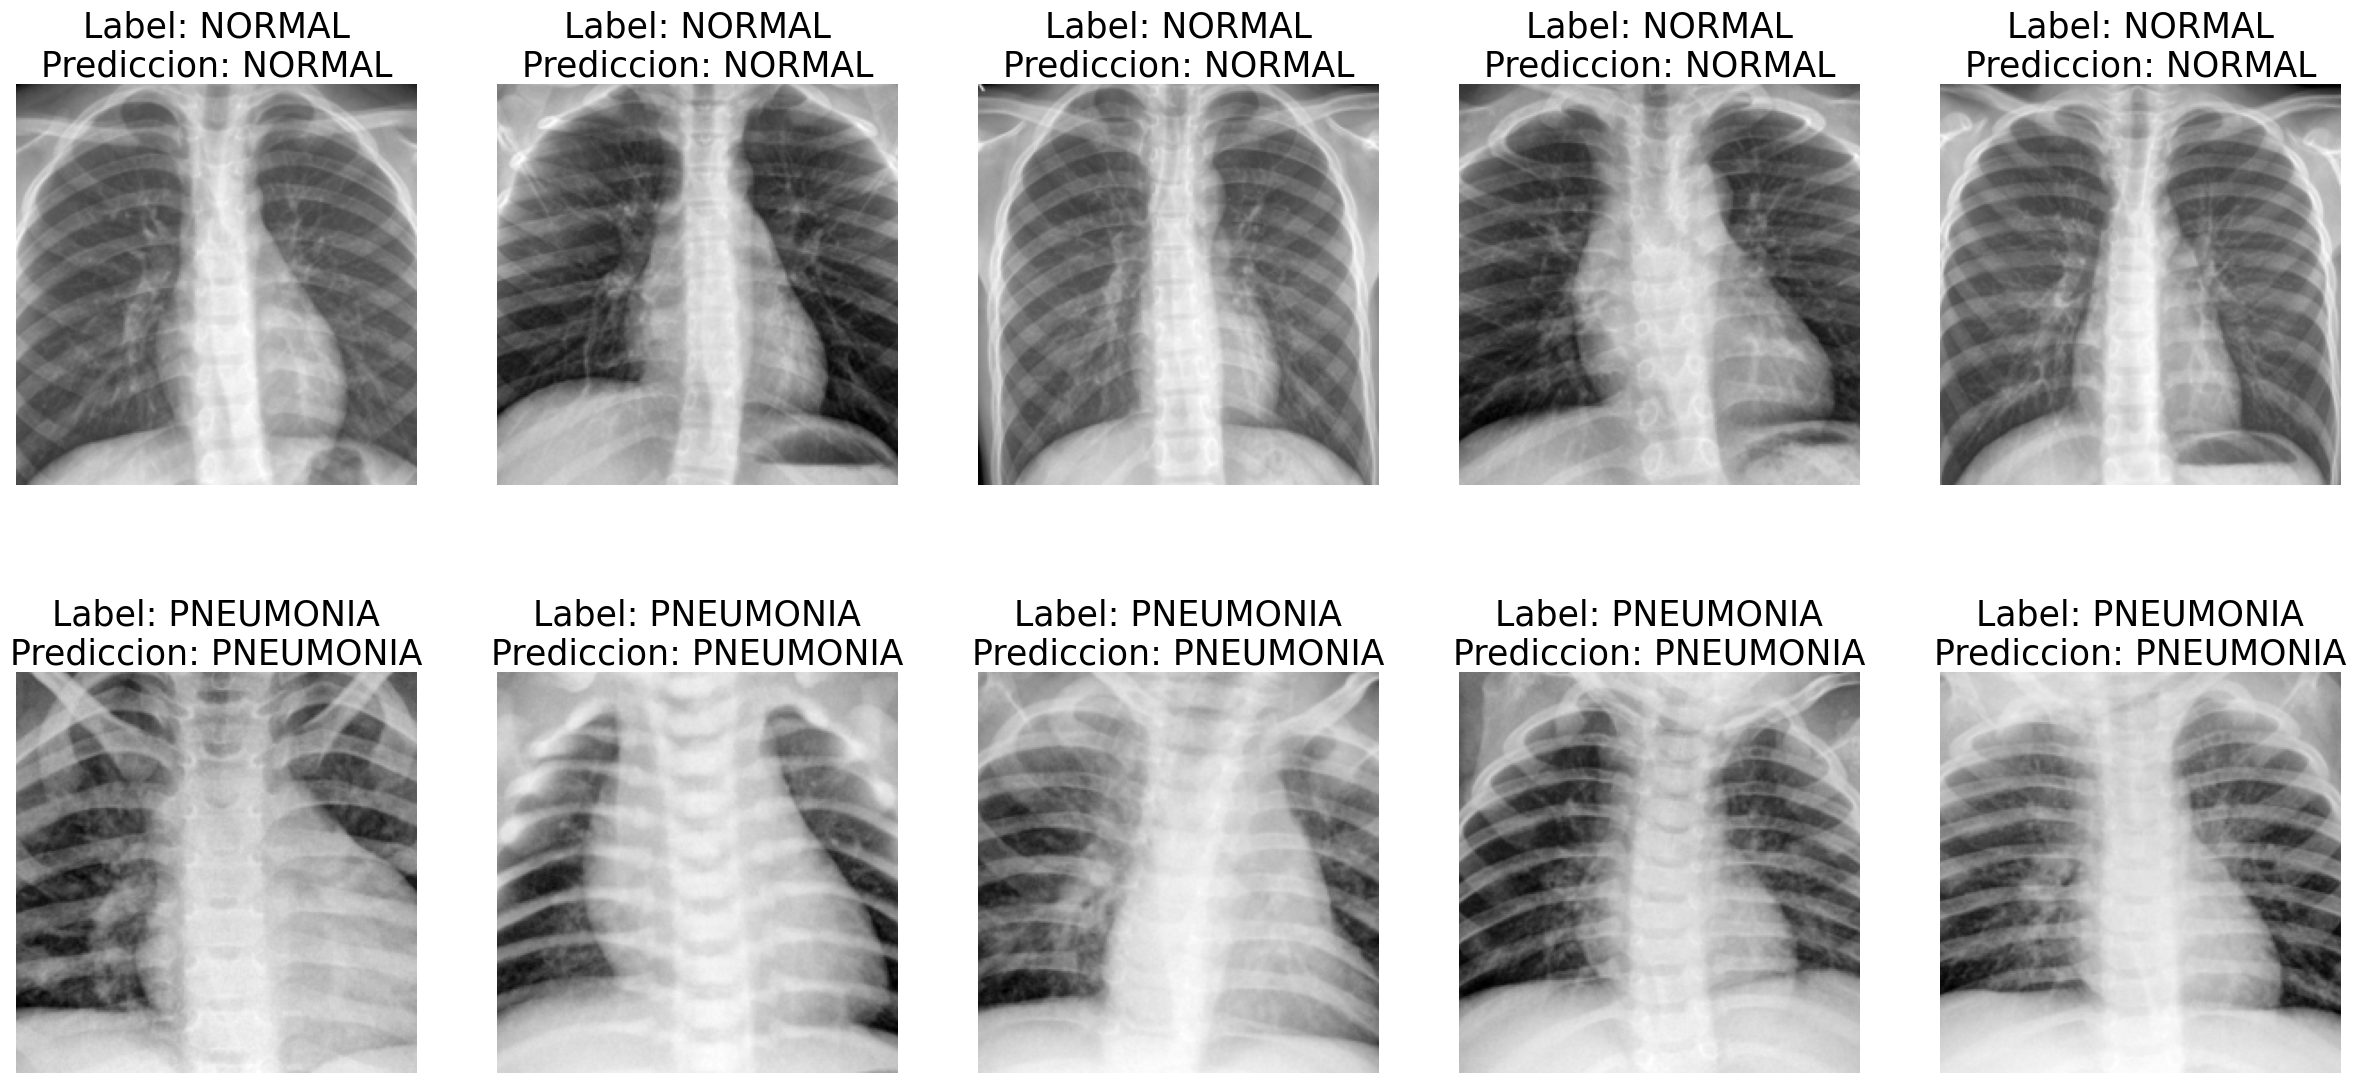

In [ ]:
# seleccione 5 índices de imágenes normales y 5 de neumonía
idxs = torch.tensor(np.append(np.arange(start=0, stop=5, step=1), 
                             np.arange(start=500, stop=505, step=1))) 

fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(30,14))

for c,i in enumerate(idxs):
    img_tensor, label = testset[i]
    ax[c//5][c%5].imshow(img_tensor[0,:,:], cmap='gray')
    ax[c//5][c%5].set_title('Label: {}\nPrediccion: {}'
                            .format(testset.classes[label], 
                                    testset.classes[preds[i]]),
                            fontsize=25)
    ax[c//5][c%5].axis('off')

También podemos ver el grado de confianza de la red neuronal en determinadas decisiones.

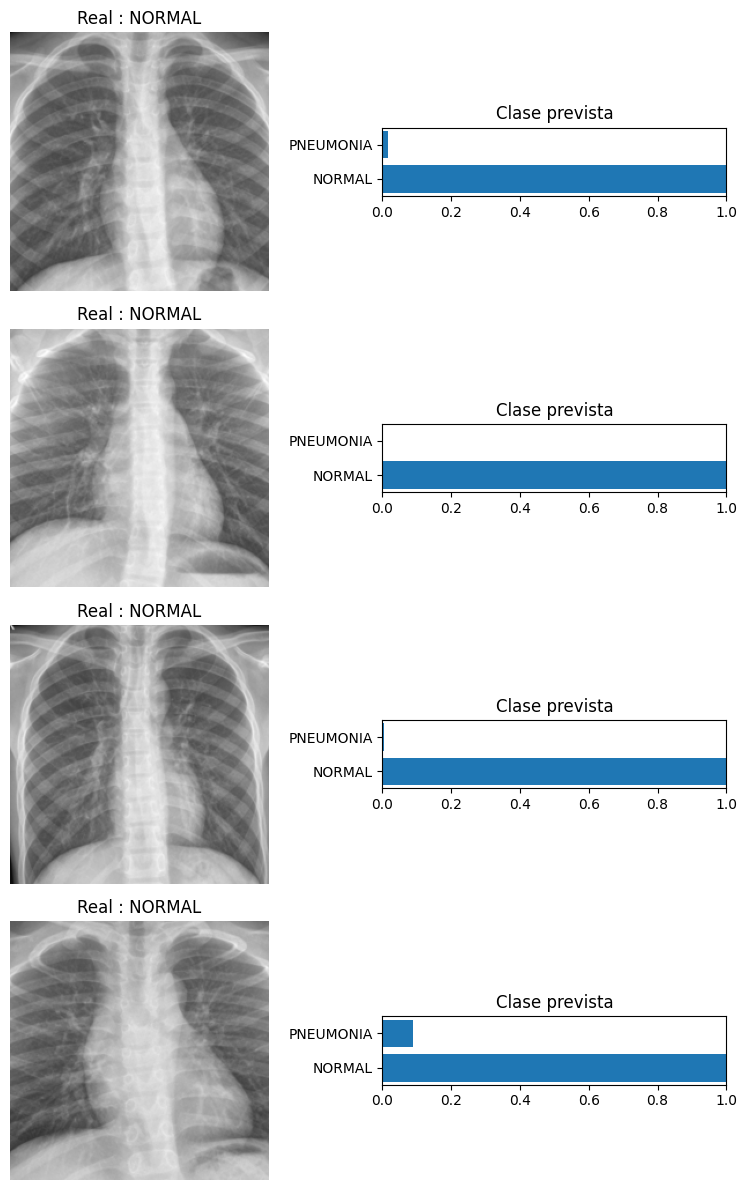

In [ ]:
fig, ax = plt.subplots(figsize=(8,12), ncols=2, nrows=4)

for row in range(4):
    img,label = testset[row]
    pred = torch.exp(model(img.to(device).unsqueeze(0)))
    class_name = ['NORMAL', 'PNEUMONIA']
    classes = np.array(class_name)
    pred = pred.cpu().data.numpy().squeeze()
    ax[row][0].imshow(img.permute(1, 2, 0))
    ax[row][0].set_title('Real : {}'.format(class_name[label]))
    ax[row][0].axis('off')
    ax[row][1].barh(classes, pred)
    ax[row][1].set_aspect(0.1)
    ax[row][1].set_yticks(classes)
    ax[row][1].set_yticklabels(classes)
    ax[row][1].set_title('Clase prevista')
    ax[row][1].set_xlim(0, 1.)
    plt.tight_layout()

## Conclusiónes



* Aquí vimos una introducción muy básica de la arquitectura DenseNet con la estructura del código y  por qué es útil y cómo son un poco mejor que la arquitectura ResNet.

* En una Densenet, la principal clave es el número de conexiones, generalmente, en cualquier arquitectura, el número de conexiones es típicamente el mismo que el número de capas, pero aquí el número de conexiones es L(L+1)/2, aquí L = número de las capas.

* Aquí la principal ventaja de la Densenet es que, si estás en la capa 3, la capa 3 toma la entrada no sólo como la capa 2, sino que también toma la entrada como la capa 1, y al hacer esto entrenamos nuestro modelo de una mejor manera y el modelo aprende mejores cosas.

* Y aquí vimos cómo usamos los datos, y entrenamos nuestro modelo con muy buena precisión y cambiando el número de tasas de abandono y el número de los valores de las capas encontramos un mejor modelo con buena precisión.

* Aquí vimos que la exactitud se incrementa y la exactitud de la siguiente época se reduce debido a la inexactitud de la oscilación local, aquí la exactitud no se reduce en los puntos mínimos, por lo que oscilan y tardan más tiempo en bajar.

* Un framework de redes neuronales muy utilizado a día de hoy. Hemos visto que Pytorch es muy similar a NumPy y comparten gran parte de su sintaxis, lo cual es una ventaja si ya sabemos trabajar con NumPy. Además, añade autograd, la capacidad de construir de manera dinámica un grafo computacional de manera que en cualquier momento podemos calcular derivadas con respecto a cualquier tensor de manera automática.

* Las diferentes maneras en las que podemos iterar por nuestros datos para entrenar un modelo en Pytorch. Si nuestro dataset es sencillo y podemos representarlo como un simple array de NumPy podemos iterar directamente el array, transformándolo previamente en un tensor. Sin embargo, cuando nuestro dataset sea más grande y no quepa en memoria o necesite cierto pre-proceso o transformaciones, es muy conveniente utilizar las clases que Pytorch nos ofrece para ello. Estas clases son, principalmente, el Dataset y el DataLoader, las cuales nos van a permitir iterar por nuestros datos de manera eficiente y generar batches de forma sencilla (además de otras funcionalidades como mezclar los datos al principio de cada epoch, cargar datos en paralelo, etc)

* Hemos visto como podemos llevar a cabo transfer learning con redes convolucionales. Aplicar esta técnica nos permitirá obtener mejores modelos con menos requisitos computacionales y con datasets reducidos. Podemos descargar una red pre-entrenada con otro dataset y aprovechar el máximo número de capas. Podemos congelar la red pre-entrenada, de manera que no se actualicen sus pesos durante el entrenamiento, y utilizarla solo como extractor de características que las nuevas capas pueden aprovechar. Aún así, hacer fine tuning (seguir entrenando la red pre-entrenada) puede dar como resultado un mejor modelo. El transfer learning es una técnica muy potente que siempre que podamos podemos aprovechar para reducir los requisitos computacionales de nuestros modelos.